In [1]:
# House keeping 1
# Impotring libraries we need
import torch
import torch.optim as opt
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Mini-batch size
mb_size = 64

# This will transform data to tensor format which is pytorch's expexted format
transform = transforms.ToTensor()

# Here we download the dataset and trnsfrom it, train=True will only download traning dataset
traindata = torchvision.datasets.MNIST('./NewData/', download=True, transform=transform, train = True)

# Loading the training data
trainloader = torch.utils.data.DataLoader(traindata, shuffle=True, batch_size=mb_size)

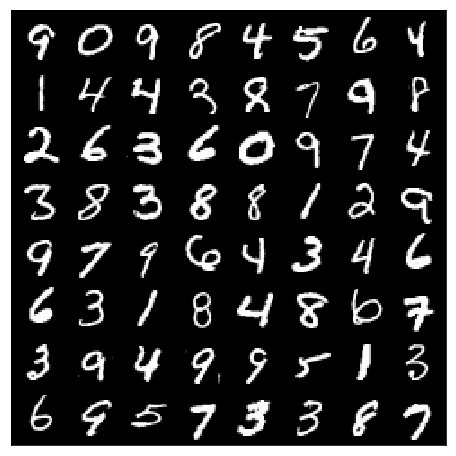

torch.Size([64, 1, 28, 28])


In [3]:
# Just as an example we are going to visualize 

# We define an iterator 

dataiter = iter(trainloader)
imgs, labels = dataiter.next()

def imshow(imgs):
    """ Visualizing images """
    # make_grid will make a grid out of images
    imgs = torchvision.utils.make_grid(imgs)
    
    # transfoming tensors to numpy arrays
    npimgs = imgs.numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(npimgs, (1,2,0)), cmap='Greys_r')
    plt.xticks([])
    plt.yticks([])
    plt.show()

imshow(imgs)

print(imgs.size())

In [4]:
# House keeping 2
# Defining the parematers of the network
h_dim = 128    # number of hidden neurons in our hidden layer
Z_dim = 100    # dimension of the input noise for generator
lr = 1e-3      # learning rate
X_dim = imgs.view(imgs.size(0), -1).size(1)
print(X_dim)

784


In [5]:
def xavier_init(m):
    """ Xavier initialization """
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0)

In [6]:
# Defining the Genrator 

class Gen(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(Z_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, X_dim),
            nn.Sigmoid()
        )
        self.model.apply(xavier_init)
    
    def forward(self, input):
        return self.model(input)
    
test = Gen()
print(test)

Gen(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=784, bias=True)
    (3): Sigmoid()
  )
)


In [7]:
# Defining the Discriminator

class Dis(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(X_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, 1),
            nn.Sigmoid()
        )
        self.model.apply(xavier_init)
    
    def forward(self, input):
        return self.model(input)
    
test = Dis()
print(test)

Dis(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


In [8]:
# Instantiating the networks
G = Gen()
D = Dis()

In [9]:
# Defining solver to do the mini batch stochastic gradient descent 
# one for each network 
G_solver = opt.Adam(G.parameters(), lr = lr)
D_solver = opt.Adam(D.parameters(), lr = lr)

# One important note
Both discriminator and genrator are competing for $D(G(z))$ term Discrimator wants to maximize it, while Generator wants to minimize it. $D(G(z))$ stands for, probablity of labling fake data correctly by discriminator. 

Epoch:0,   G_loss:6.224934215993007,   D_loss:0.06418865949991764


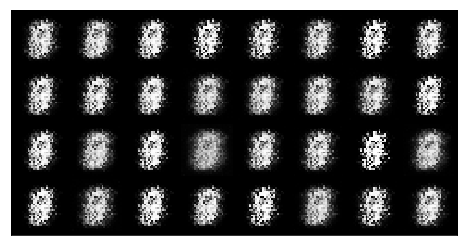

Epoch:1,   G_loss:5.205840351230808,   D_loss:0.0541194095862096


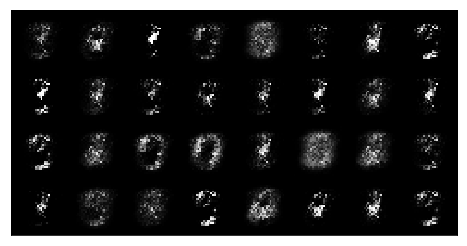

Epoch:2,   G_loss:4.822119927101298,   D_loss:0.11688164074315445


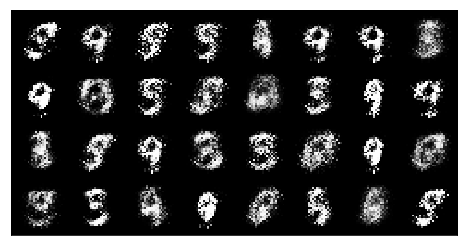

Epoch:3,   G_loss:5.397543158358348,   D_loss:0.1798635782606439


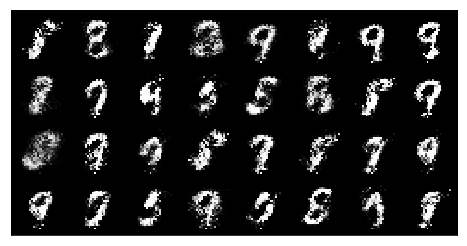

Epoch:4,   G_loss:4.598344832595223,   D_loss:0.26153365498396763


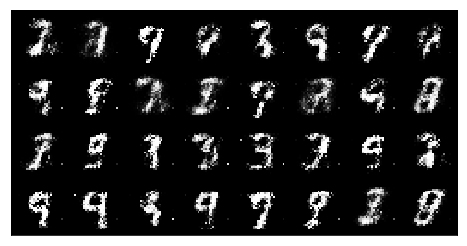

Epoch:5,   G_loss:4.255343845912388,   D_loss:0.34142708723574305


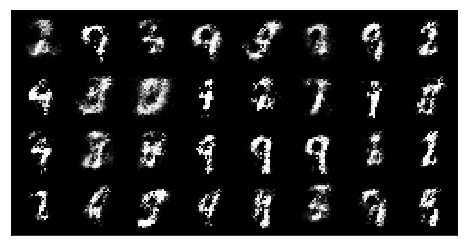

Epoch:6,   G_loss:3.8408133914984113,   D_loss:0.43263790696096827


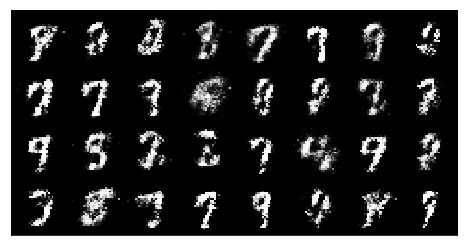

Epoch:7,   G_loss:3.467876998092066,   D_loss:0.5023685270694019


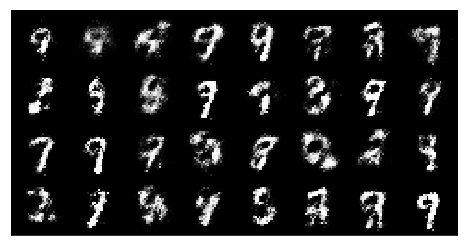

Epoch:8,   G_loss:3.07641848953548,   D_loss:0.5817859348997887


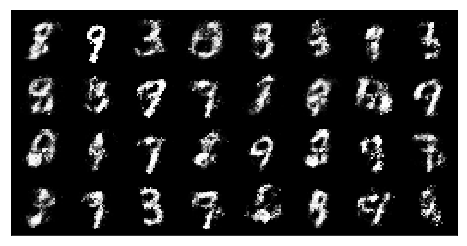

Epoch:9,   G_loss:2.939556120555284,   D_loss:0.6688896979350271


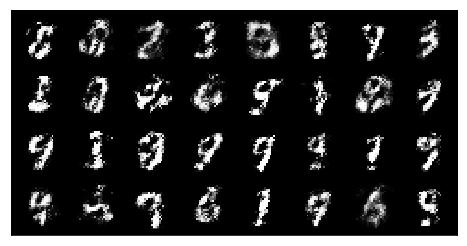

Epoch:10,   G_loss:2.523341770365294,   D_loss:0.7172684785780876


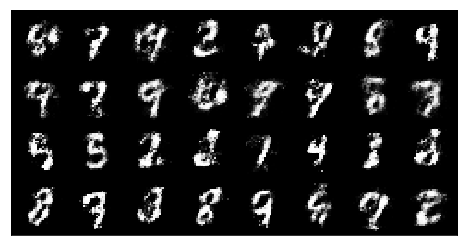

Epoch:11,   G_loss:2.383204916138639,   D_loss:0.7725671612059892


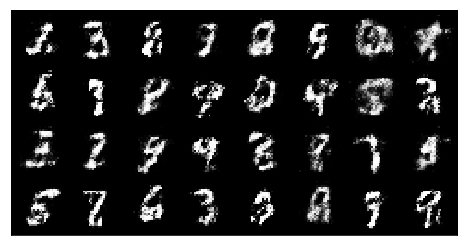

Epoch:12,   G_loss:2.398156135448261,   D_loss:0.774137877452094


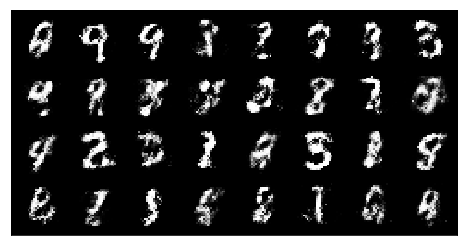

Epoch:13,   G_loss:2.3352510148782466,   D_loss:0.7839607259294371


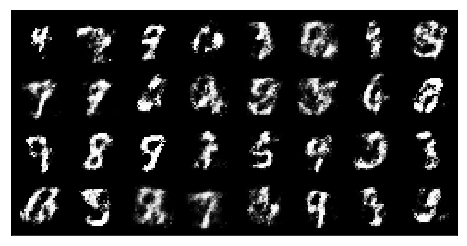

Epoch:14,   G_loss:2.16093350524333,   D_loss:0.7924455367743588


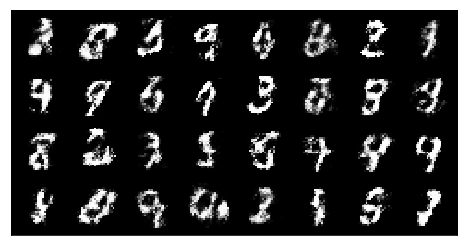

Epoch:15,   G_loss:2.098160181853817,   D_loss:0.7879143208900748


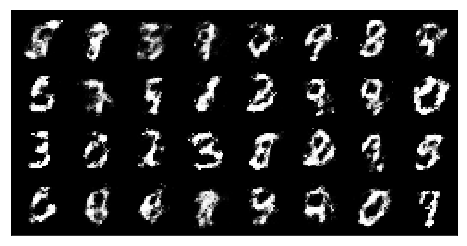

Epoch:16,   G_loss:2.0808363762745725,   D_loss:0.7947819356852249


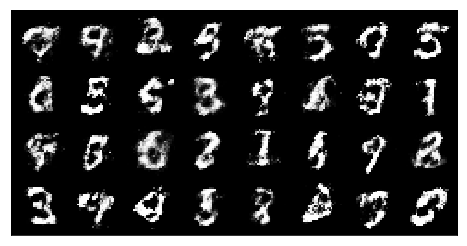

Epoch:17,   G_loss:2.0269424156593616,   D_loss:0.8041162177570848


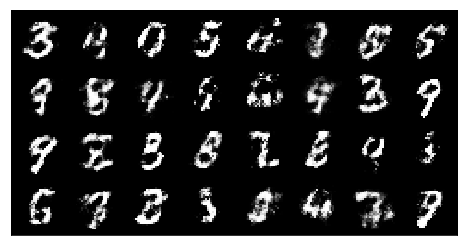

Epoch:18,   G_loss:1.9041220834260302,   D_loss:0.8168720827936363


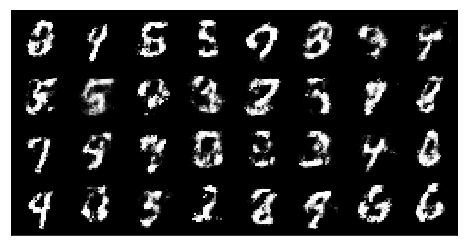

Epoch:19,   G_loss:1.9635832218218967,   D_loss:0.788797489011974


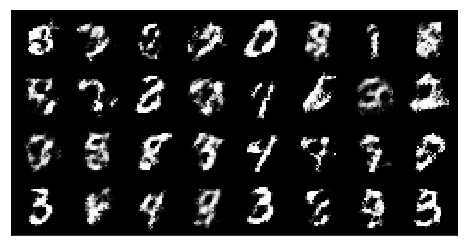

In [10]:
# Defining the training for loop
for epoch in range(20):
    G_loss_run = 0.0
    D_loss_run = 0.0
    for i,data in enumerate(trainloader):
        X, _ = data
        X = X.view(X.size(0), -1)
        mb_size = X.size(0)
        
        # Definig labels for real (1s) and fake (0s) images
        one_labels = torch.ones(mb_size, 1)
        zero_labels = torch.zeros(mb_size, 1)
        
        # Random normal distribution for each image
        z = torch.randn(mb_size, Z_dim)
        
        
        # Feed forward in discriminator both 
        # fake and real images
        D_real = D(X)
        # fakes = G(z)
        D_fake = D(G(z))
        
        # Defining the loss for Discriminator
        D_real_loss = F.binary_cross_entropy(D_real, one_labels)
        D_fake_loss = F.binary_cross_entropy(D_fake, zero_labels)
        D_loss = D_fake_loss + D_real_loss
        
        # backward propagation for discriminator
        D_solver.zero_grad()
        D_loss.backward()
        D_solver.step()
        
        # Feed forward for generator
        z = torch.randn(mb_size, Z_dim)
        D_fake = D(G(z))
        
        # loss function of generator
        G_loss = F.binary_cross_entropy(D_fake, one_labels)
        
        # backward propagation for generator
        G_solver.zero_grad()
        G_loss.backward()
        G_solver.step()
        
        G_loss_run += G_loss.item()
        D_loss_run += D_loss.item()
        
    # printing loss after each epoch 
    print('Epoch:{},   G_loss:{},   D_loss:{}'.format(epoch, G_loss_run/(i+1), D_loss_run/(i+1) ))
    
    # Plotting fake images generated after each epoch by generator
    samples = G(z).detach()
    samples = samples.view(samples.size(0), 1, 28, 28)
    imshow(samples)
        
        